# exploring the math behind roobet's game towers

towers is a game on the popular crypto currency gambling site roobet. it consists of a number of levels each with a mine hidden somewhere inside. the player picks a space and if there is not a mine there they continue and their bet is multiplied, otherwise they lose their bet. the game has three different difficulties: easy, medium and hard. the easy difficulty has eight levels of three wide rows each with one mine placed randomly in them. the medium difficulty has eight levels of two wide rows each with one mine inside. finally, the hard difficulty has eight levels of three wide rows with two mines inside. with the higher difficulty comes a higher multipler; easy, medium and hard have max multipliers of 20.09x, 200.64x, and 5142.14x respectively. 

in this project i will be exploring the probabilites and strategies of the game of towers on roobet.

### necessary libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

### recreating roobet's version of towers with the game function
as well as the game function, and multiplier dictionaries, a class of game results is created to simplify working with the data later.

In [4]:
class game_results:
    def __init__(self, money_change, rows_cleared):
        self.money_change = money_change
        self.rows_cleared = rows_cleared

multis = {
    'easy': [1.46, 2.12, 3.08, 4.48, 6.52, 9.49, 13.81, 20.09],
    'medium': [1.94, 3.76, 7.30, 14.16, 27.48, 53.31, 103.42, 200.64],
    'hard': [2.91, 8.47, 24.64, 71.71, 208.67, 607.24, 1767.06, 5142.14]
}
widths = {'easy': 3, 'medium': 2, 'hard': 3}
mines_per_row = {'easy': 1, 'medium': 1, 'hard': 2}

def play_game(difficulty, wager, cashout_at, choose_space = 'random'):
    multi = multis[difficulty]
    width = widths[difficulty]
    mines = mines_per_row[difficulty]
                 
    board = [[0 for x in range(width)] for y in range(9)]
    for row in board:
        if mines == 1:
            row[random.randint(0, len(row)-1)] = 1
        else:
            first_mine = random.randint(0, len(row)-1)
            second_mine = random.randint(0, len(row)-1)
            while first_mine == second_mine:
                second_mine = random.randint(0, len(row)-1)
            row[first_mine] = 1
            row[second_mine] = 1    
    # for row in board: print(row)
    
    rows_cleared = 0
    for row in board:
        if choose_space == 'random':
            space_chosen = random.randint(0, len(row)-1)
        else:
            space_chosen = choose_space
        # print(space_chosen)
        
        if row[space_chosen] == 1:
            return (wager * -1, rows_cleared)
        else:
            rows_cleared += 1
            if cashout_at == rows_cleared:
                return ((wager * (multi[rows_cleared - 1]) - wager), rows_cleared)

#### example games to test game function

In [24]:
balance = 100
n_games = 4
difficulty = 'easy'
wager = 25
cashout_at = 3
space = 'random'

print('your starting balance is ${}.'.format(balance))
for i in range(1, n_games + 1):
    print('game {} of {}:'.format(i, n_games))
    results = game_results(*(play_game(difficulty, wager, cashout_at, space)))
    balance += results.money_change
    if results.money_change > 0:
        print('\t you cleared {} of 3 levels and won ${}'.format(results.rows_cleared, results.money_change))
        print('\t your balance is ${}.'.format(balance))
    else:
        print('\t you cleared {} of 3 levels and lost ${}'.format(results.rows_cleared, results.money_change * -1))
        print('\t your balance is ${}.'.format(balance))

your starting balance is $100.
game 1 of 4:
	 you cleared 3 of 3 levels and won $52.0
	 your balance is $152.0.
game 2 of 4:
	 you cleared 0 of 3 levels and lost $25
	 your balance is $127.0.
game 3 of 4:
	 you cleared 2 of 3 levels and lost $25
	 your balance is $102.0.
game 4 of 4:
	 you cleared 3 of 3 levels and won $52.0
	 your balance is $154.0.


### calculating the expected value

#### the expected value function
the expected value function shows us that the game is programmed in a way such that the expected loss is the nearly same regardless of difficulty or cashout point.

In [27]:
def calculate_ev(difficulty, wager, cashout_at):
    multi = multis[difficulty]
    if difficulty == 'easy':
        prob_loss = (1 - (2 / 3)**cashout_at)
    elif difficulty == 'medium':
        prob_loss = (1 - (1 / 2)**cashout_at)
    else:
        prob_loss = (1 - (1 / 3)**cashout_at)
    
    ev = prob_loss*(-1*wager) + (1 - prob_loss)*((multi[cashout_at-1]*wager) - wager)
    return ev

print('testing expected value function:')
wager = 1
cashout_at = 8
print('\twager = {}, cashout point = {}'.format(wager, cashout_at))
print('\texpected loss for easy difficulty:', calculate_ev('easy', wager, cashout_at))
print('\texpected loss for medium difficulty:', calculate_ev('medium', wager, cashout_at))
print('\texpected loss for hard difficulty:', calculate_ev('hard', wager, cashout_at))

testing expected value function:
	wager = 1, cashout point = 8
	expected loss for easy difficulty: -0.21611949397957697
	expected loss for medium difficulty: -0.21625000000000005
	expected loss for hard difficulty: -0.21625666819059552


#### visualization

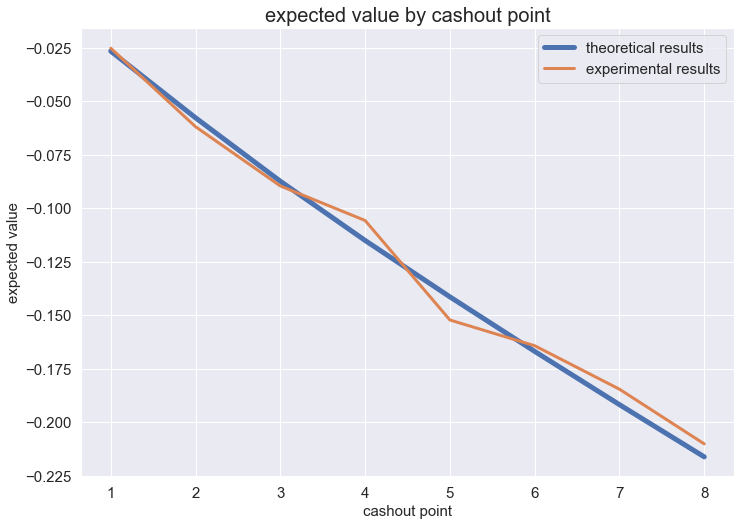

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sample_size = 100000
difficulty = 'easy'
wager = 1

xs = range(1, 9)
ys = [calculate_ev(difficulty, wager, i) for i in range(1, 9)]

y2s = []
for i in range(1, 9):
    outcomes = []
    for n in range(sample_size):
        result = game_results(*(play_game(difficulty, wager, i)))
        outcomes.append(result.money_change)
    average = sum(outcomes)/len(outcomes)
    y2s.append(average)
    
plt.plot(xs, ys, linewidth=5)
plt.xlabel("cashout point", fontsize=15)
plt.ylabel("expected value", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(xs, y2s, linewidth=3)
plt.title("expected value by cashout point", fontsize=20)
plt.legend(["theoretical results", "experimental results"], fontsize=15)
plt.show()

### visualizing/calculating the number of games reach a certain point

first we look at the percentage of games that reach a certain multiplier.

[0.5009, 0.2499, 0.1231, 0.0612, 0.0307, 0.0161, 0.0082, 0.0046]


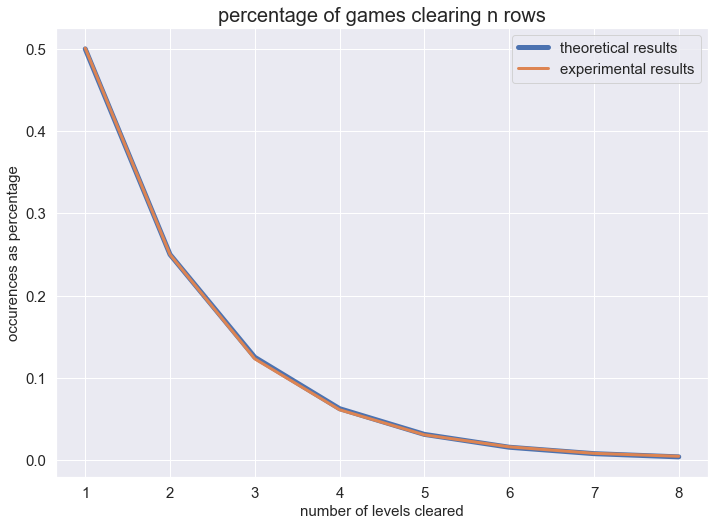

In [30]:
sample_size = 10000
difficulty = 'medium'
wager = 1

rows_cleared = []
for n in range(sample_size):
    result = game_results(*(play_game(difficulty, wager, 8)))
    rows_cleared.append(result.rows_cleared)

xs = range(1,9)
ys = []
for i in range(1, 9):
    if difficulty == 'easy':
        ys.append((2 / 3)**i)
    elif difficulty == 'medium':
        ys.append((1 / 2)**i)
    else:
        ys.append((1 / 3)**i)

y2s = [] 
for n in range(1, 9):
    counter = 0
    for num in rows_cleared:
        if num >= n:
            counter += 1
    percentage = counter / len(rows_cleared)     
    y2s.append(percentage)
print(y2s)
    
plt.plot(xs, ys, linewidth=5)
plt.plot(xs, y2s, linewidth=3)
plt.title('percentage of games clearing n rows', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('number of levels cleared', fontsize=15)
plt.ylabel('occurences as percentage', fontsize=15)
plt.legend(["theoretical results", "experimental results"], fontsize=15)
plt.show()

here the same data is plotted in a histogram. a very interesting trend appears where the final row is cleared more often than the ones before. i believe this is because these games may have made it further to 10, 1000, ... to infinity but they were stopped short. so this final bin represents the sum of the games that would have reached 9-infinity.

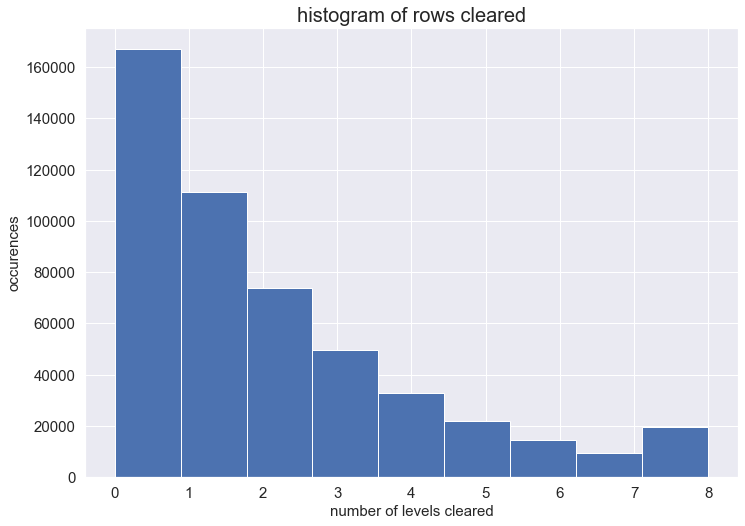

In [11]:
plt.hist(rows_cleared, bins = 9)
plt.title('histogram of rows cleared', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('number of levels cleared', fontsize=15)
plt.ylabel('occurences', fontsize=15)
plt.show()

### strategies
in this section we will compare different strategies to see how they compare to the random one.

#### go where the bomb was before strategy
for this strategy we will need to make a modification to the game function. since there are two mines in the hard difficulty this function will only work with easy and medium.

In [12]:
def go_where_bomb_was(difficulty, wager, cashout_at):
    multi = multis[difficulty]
    width = widths[difficulty]
    mines = mines_per_row[difficulty]
                 
    board = [[0 for x in range(width)] for y in range(8)]
    for row in board:
        if mines == 1:
            row[random.randint(0, len(row)-1)] = 1
        else:
            first_mine = random.randint(0, len(row)-1)
            second_mine = random.randint(0, len(row)-1)
            while first_mine == second_mine:
                second_mine = random.randint(0, len(row)-1)
            row[first_mine] = 1
            row[second_mine] = 1    
    
    rows_cleared = 0
    previous_mine = random.randint(0, len(row)-1)
    for row in board:
        if row[previous_mine] == 1:
            return (wager * -1, rows_cleared)
        else:
            rows_cleared += 1
            if cashout_at == rows_cleared:
                return ((wager * (multi[rows_cleared - 1]) - wager), rows_cleared)
        previous_mine = row.index(1)

#### visualization of go where the bomb was before strategy
in roobets version you can't actually see where the bomb was before so you could not implemenet this strategy. it ends up not mattering as each level is independent and this strategy should results in the same outcome as randomly picking a place.

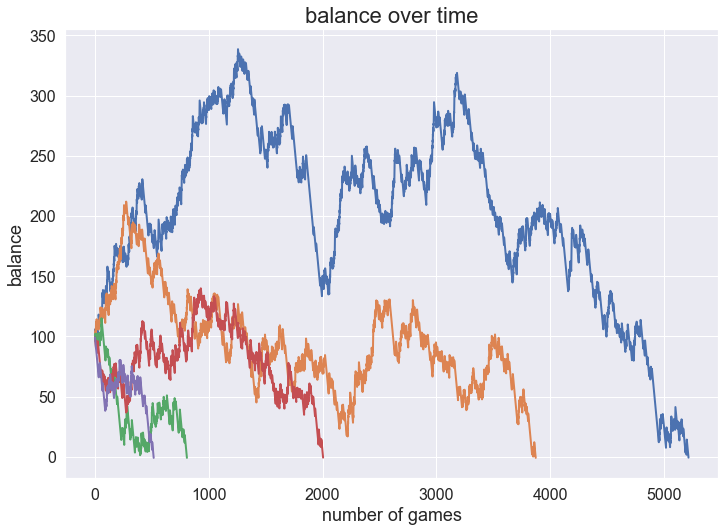

In [38]:
balance = 100
difficulty = 'medium'
wager = 1
cashout_at = 3

def play_go_where_bomb_was(balance):  
    balance_history = []
    while balance > 0:
        results = game_results(*(go_where_bomb_was(difficulty, wager, cashout_at)))
        balance += results.money_change
        balance_history.append(balance)
    return balance_history

for i in range(5):
    plt.plot(play_go_where_bomb_was(balance), linewidth=2)
    
plt.xlabel("number of games", fontsize=18)
plt.ylabel("balance", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("balance over time", fontsize=22)
plt.show()

#### always pick the same spot strategy
this strategy can easily be tested due to the way the game function was programmed in the beginning. all we need to due is change the choose_space variable.

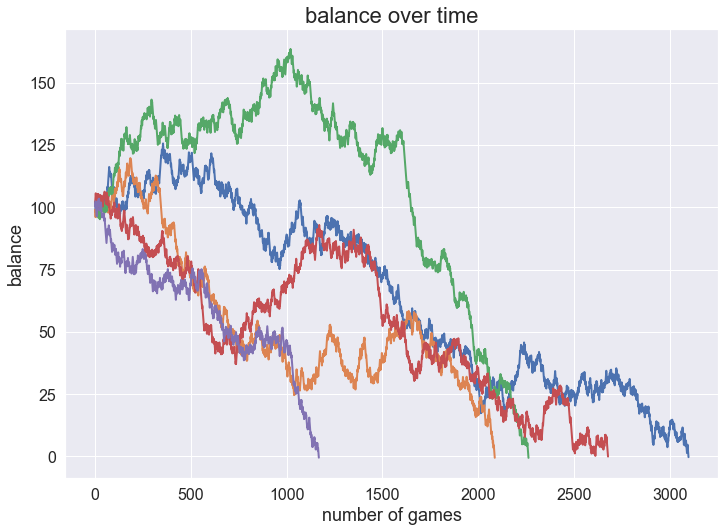

In [47]:
balance = 100
difficulty = 'easy'
wager = 1
cashout_at = 2
choose_space = 1

def play_same_space(balance):  
    balance_history = []
    while balance > 0:
        results = game_results(*(play_game(difficulty, wager, cashout_at, choose_space)))
        balance += results.money_change
        balance_history.append(balance)
    return balance_history

for i in range(5):
    plt.plot(play_same_space(balance), linewidth=2)
    
plt.xlabel("number of games", fontsize=18)
plt.ylabel("balance", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("balance over time", fontsize=22)
plt.show()